We will be using the Credit Card Fraud Detection Dataset from Kaggle.

Total Samples: 28481
Fraudulent Cases: 46 (0.1615%)
Loading cached model: logistic_model.pkl
Loading cached model: rf_model.pkl
Loading cached model: xgb_model.pkl

=== Evaluation Summary ===
                 Model  Accuracy  Precision  Recall  F1 Score       AUC
0  Logistic Regression  0.521678   0.003292     1.0  0.006562  0.966616
1        Random Forest  0.999824   0.900000     1.0  0.947368  0.999941
2              XGBoost  0.998069   0.450000     1.0  0.620690  1.000000


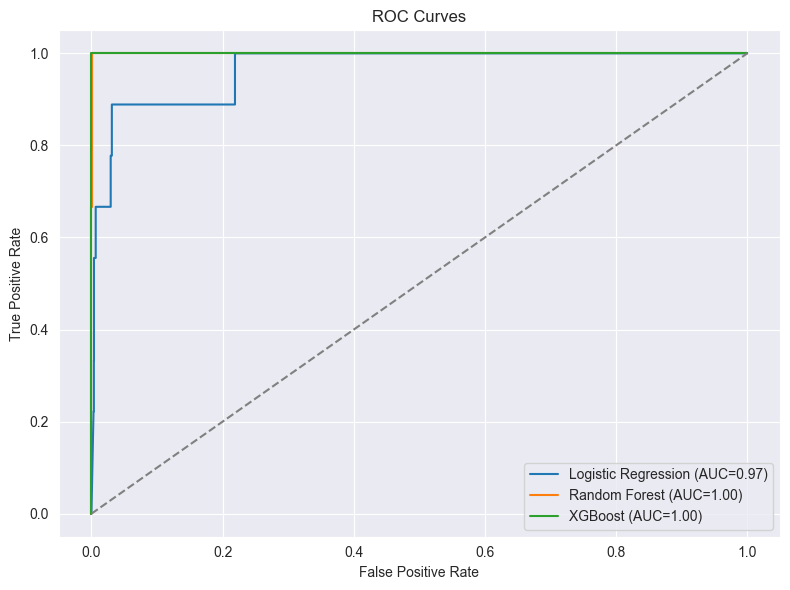

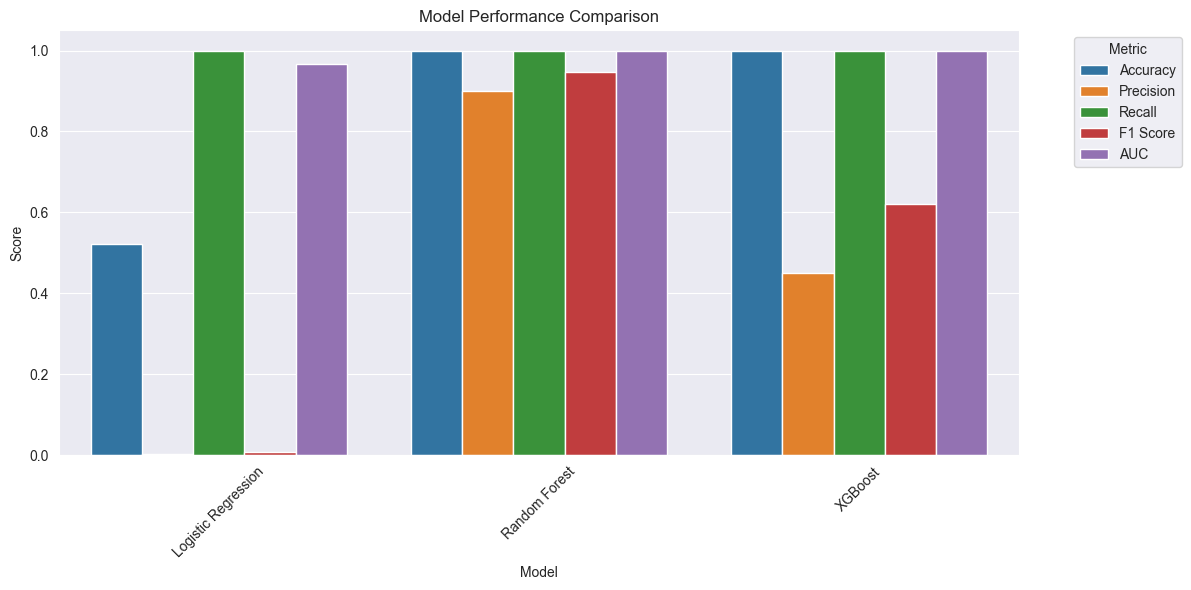

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (
    roc_curve, roc_auc_score, accuracy_score,
    recall_score, precision_score, f1_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

# Constants
DATA_PATH = "data/creditcard.csv"
RANDOM_STATE = 42
TEST_SIZE = 0.2
CV_SPLITS = 3
USE_SAMPLE = True  # Toggle to False for full dataset


def load_dataset(file_path):
    df = pd.read_csv(file_path)
    return df.sample(frac=0.1, random_state=RANDOM_STATE) if USE_SAMPLE else df


def preprocess_data(dataset):
    scaler = RobustScaler()
    dataset[["Time", "Amount"]] = scaler.fit_transform(dataset[["Time", "Amount"]])
    return dataset


def dataset_summary(dataset):
    fraud = dataset["Class"].sum()
    total = len(dataset)
    print(f"Total Samples: {total}")
    print(f"Fraudulent Cases: {fraud} ({fraud / total:.4%})")


def evaluate_model(estimator, param_grid, sampling, X_train, y_train, X_test, y_test, model_name):
    cache_path = f"{model_name}_model.pkl"

    pipeline = make_pipeline(sampling, estimator)

    if os.path.exists(cache_path):
        print(f"Loading cached model: {cache_path}")
        model = joblib.load(cache_path)
    else:
        print(f"Training {model_name}...")
        search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=param_grid,
            n_iter=5,
            scoring='f1',
            cv=StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE),
            n_jobs=-1,
            verbose=1,
            random_state=RANDOM_STATE
        )
        search.fit(X_train, y_train)
        model = search.best_estimator_
        joblib.dump(model, cache_path)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    fpr, tpr = roc_curve(y_test, y_proba)[:2] if y_proba is not None else (None, None)

    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else None,
        "FPR/TPR": (fpr, tpr)
    }
    return model, metrics


def plot_roc_curves(metrics_dict):
    plt.figure(figsize=(8, 6))
    for name, m in metrics_dict.items():
        fpr, tpr = m["FPR/TPR"]
        if fpr is not None:
            plt.plot(fpr, tpr, label=f"{name} (AUC={m['AUC']:.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_metric_comparison(results_df):
    melted = results_df.drop(columns=["FPR/TPR"]).melt(id_vars="Model")
    plt.figure(figsize=(12, 6))
    sns.barplot(data=melted, x="Model", y="value", hue="variable")
    plt.title("Model Performance Comparison")
    plt.ylabel("Score")
    plt.xlabel("Model")
    plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # Load & prepare data
    df = load_dataset(DATA_PATH)
    dataset_summary(df)
    df = preprocess_data(df)

    X = df.drop("Class", axis=1)
    y = df["Class"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )

    # Model configs
    lr_params = {
        "logisticregression__penalty": ["l1", "l2"],
        "logisticregression__C": [0.1, 1, 10],
        "logisticregression__solver": ["liblinear"]
    }
    rf_params = {
        "randomforestclassifier__n_estimators": [100],
        "randomforestclassifier__max_depth": [None, 10],
        "randomforestclassifier__min_samples_split": [2]
    }
    xgb_params = {
        "xgbclassifier__n_estimators": [100],
        "xgbclassifier__learning_rate": [0.1],
        "xgbclassifier__max_depth": [3, 6]
    }

    # Train & evaluate models
    lr_model, lr_metrics = evaluate_model(
        LogisticRegression(), lr_params, NearMiss(), X_train, y_train, X_test, y_test, "logistic"
    )
    rf_model, rf_metrics = evaluate_model(
        RandomForestClassifier(random_state=RANDOM_STATE), rf_params, SMOTE(), X_train, y_train, X_test, y_test, "rf"
    )
    xgb_model, xgb_metrics = evaluate_model(
        XGBClassifier(use_label_encoder=False, eval_metric="logloss", n_jobs=-1, random_state=RANDOM_STATE),
        xgb_params, SMOTE(), X_train, y_train, X_test, y_test, "xgb"
    )

    # Prepare results
    results_df = pd.DataFrame([
        {"Model": "Logistic Regression", **lr_metrics},
        {"Model": "Random Forest", **rf_metrics},
        {"Model": "XGBoost", **xgb_metrics}
    ])

    print("\n=== Evaluation Summary ===")
    print(results_df.drop(columns=["FPR/TPR"]))

    # Visualizations
    metrics_dict = {
        "Logistic Regression": lr_metrics,
        "Random Forest": rf_metrics,
        "XGBoost": xgb_metrics
    }
    plot_roc_curves(metrics_dict)
    plot_metric_comparison(results_df)
